In [95]:
# CyberLab session clustering notebook

# Pulls session-level features from CyberLab after Tukey filtering on time_diff
# File: cyberlab_session_features_tukey_time_ts.csv
# Performs KMeans clustering (excluding SQL injection sample)
# Uses elbow + silhouette to pick k
# Visualises clusters in PCA space

# Imports & plotting style

import os
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from math import pi

# HARD RESET OF STYLE
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("default")
sns.set_theme(style="whitegrid")

plt.rcParams.update({
    "figure.max_open_warning": 0,
    "figure.facecolor": "white",
    "axes.facecolor": "white",
})

os.makedirs("output", exist_ok=True)


In [96]:
# Load session-level features & basic info

SESSION_FEATURES_PATH = "output/cyberlab_session_features_tukey_time_ts.csv"

df_sess = pd.read_csv(SESSION_FEATURES_PATH)

print("=== Loaded session-level features ===")
print(f"Rows (sessions): {len(df_sess):,}")
print(f"Columns: {list(df_sess.columns)}\n")

# Parse timestamps (not strictly needed for clustering, but useful)
for col in ["session_start", "session_end"]:
    if col in df_sess.columns:
        df_sess[col] = pd.to_datetime(
            df_sess[col],
            utc=True,
            format="mixed",
            errors="coerce",
        )

print("=== Per-sample session counts (ALL samples) ===")
print(df_sess["sample"].value_counts())


=== Loaded session-level features ===
Rows (sessions): 175
Columns: ['sample', 'sandbox_id', 'n_pairs', 'session_start', 'session_end', 'mean_ts', 'median_ts', 'std_ts', 'min_ts', 'max_ts', 'mean_dt', 'median_dt', 'std_dt', 'min_dt', 'max_dt', 'mean_len', 'median_len', 'std_len', 'min_len', 'max_len', 'session_duration_s', 'total_time_diff', 'total_cmd_len', 'avg_time_per_char', 'prop_fast_ts', 'prop_short_dt', 'prop_long_dt']

=== Per-sample session counts (ALL samples) ===
sample
Junior hacker adaptive     58
Kobylka 3302               46
House of cards             22
Junior hacker              18
Secret laboratory          13
Webmin exploit practice    10
SQL injection               8
Name: count, dtype: int64


In [97]:
# Drop SQL injection sessions

df_clust = df_sess[df_sess["sample"] != "SQL injection"].copy()

# Uncomment below if you want to retain SQL injection for clustering
# df_clust = df_sess.copy()

print("=== Per-sample session counts (excluding SQL injection) ===")
print(df_clust["sample"].value_counts())
print(f"\nSessions retained for clustering: {len(df_clust):,}")


=== Per-sample session counts (excluding SQL injection) ===
sample
Junior hacker adaptive     58
Kobylka 3302               46
House of cards             22
Junior hacker              18
Secret laboratory          13
Webmin exploit practice    10
Name: count, dtype: int64

Sessions retained for clustering: 167


In [124]:
# Select core features for clustering

# Features chosen to capture:
# - median typing speed and delay (robust to outliers)
# - total "volume" (n_pairs)
# - proportion of very fast typing (paste/script bursts)
# - proportion of long pauses
# - proportion of short pauses
# - typical command length (median_len)

features = [
    "median_ts",      # speed (chars/s)
    "median_dt",      # thinking time (s)
    "n_pairs",        # session volume
    "prop_fast_ts",   # burstiness / paste-scripts
    "prop_long_dt",   # long pauses
    "prop_short_dt",  # short pauses
    "median_len",     # typical command length
]

# Keep only those columns that exist just in case
features = [c for c in features if c in df_clust.columns]

print("Using features for clustering:")
for f in features:
    print("  -", f)

X = df_clust[features].copy()

# Quick summary
print("\n=== Summary of selected features (raw space) ===")
display(X.describe().T.round(3))


Using features for clustering:
  - median_ts
  - median_dt
  - n_pairs
  - prop_fast_ts
  - prop_long_dt
  - prop_short_dt
  - median_len

=== Summary of selected features (raw space) ===


,count,mean,std,min,25%,50%,75%,max
median_ts,167.0,102.928,1204.370,0.101,0.574,0.859,1.372,15500.000
median_dt,167.0,20.527,21.144,0.001,8.000,15.326,28.639,208.890
n_pairs,167.0,66.317,44.143,3.000,35.000,57.000,86.500,306.000
prop_fast_ts,167.0,0.048,0.101,0.000,0.000,0.012,0.047,0.750
prop_long_dt,167.0,0.189,0.159,0.000,0.052,0.149,0.313,0.778
prop_short_dt,167.0,0.033,0.095,0.000,0.000,0.000,0.017,0.750
median_len,167.0,13.626,8.017,2.000,10.000,12.000,16.000,64.000


In [99]:
# Log-transform skewed features (time + counts)

# These are expected to be heavy-tailed, so we work in log-space
log_features = ["n_pairs", "median_dt", "median_ts"]
log_features = [c for c in log_features if c in X.columns]

for col in log_features:
    X[col] = np.log1p(X[col])

print("Log-transformed columns:", log_features)

print("\n=== Summary of features after log-transform (where applied) ===")
display(X.describe().T.round(3))


Log-transformed columns: ['n_pairs', 'median_dt', 'median_ts']

=== Summary of features after log-transform (where applied) ===


,count,mean,std,min,25%,50%,75%,max
median_ts,167.0,0.757,0.913,0.096,0.454,0.620,0.864,9.649
median_dt,167.0,2.772,0.783,0.001,2.197,2.793,3.389,5.347
n_pairs,167.0,3.986,0.730,1.386,3.584,4.060,4.471,5.727
prop_fast_ts,167.0,0.048,0.101,0.000,0.000,0.012,0.047,0.750
prop_long_dt,167.0,0.189,0.159,0.000,0.052,0.149,0.313,0.778
prop_short_dt,167.0,0.033,0.095,0.000,0.000,0.000,0.017,0.750
median_len,167.0,13.626,8.017,2.000,10.000,12.000,16.000,64.000


In [100]:
# Standardise features

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled feature matrix shape:", X_scaled.shape)


Scaled feature matrix shape: (167, 7)


In [129]:
# # KMeans model selection with elbow + silhouette
#
# k_range = range(2, 9)
# inertias = []
# sil_scores = []
#
# for k in k_range:
#     kmeans_k = KMeans(
#         n_clusters=k,
#         random_state=42,
#         n_init=10,
#     )
#     labels_k = kmeans_k.fit_predict(X_scaled)
#     inertias.append(kmeans_k.inertia_)
#     sil = silhouette_score(X_scaled, labels_k)
#     sil_scores.append(sil)
#
# # Plot elbow (inertia) and silhouette
# fig, ax = plt.subplots(1, 2, figsize=(12, 5))
#
# # Elbow
# ax[0].plot(list(k_range), inertias, marker="o")
# ax[0].set_xlabel("k (number of clusters)")
# ax[0].set_ylabel("Inertia (sum of squared distances)")
# ax[0].set_title("KMeans elbow plot")
#
# # Silhouette
# ax[1].plot(list(k_range), sil_scores, marker="o")
# ax[1].set_xlabel("k (number of clusters)")
# ax[1].set_ylabel("Silhouette score")
# ax[1].set_title("KMeans silhouette scores")
#
# plt.tight_layout()
# plt.savefig("output/kmeans_elbow_silhouette.png", dpi=150)
# plt.show()
#
# for k, inert, sil in zip(k_range, inertias, sil_scores):
#     print(f"k={k}: inertia={inert:.1f}, silhouette={sil:.3f}")
#
# # Choose best k as the one with the highest silhouette score
# best_k = int(k_range[int(np.argmax(sil_scores))])
# print(f"\nChosen number of clusters (max silhouette): k = {best_k}")


In [130]:
# Fit final KMeans model with chosen k and assign clusters

kmeans = KMeans(
    n_clusters=5,
    random_state=42,
    n_init=10,
)
cluster_labels = kmeans.fit_predict(X_scaled)

df_clust["cluster"] = cluster_labels

print("=== Cluster counts ===")
print(df_clust["cluster"].value_counts().sort_index())


=== Cluster counts ===
cluster
0     8
1    82
2     2
3    69
4     6
Name: count, dtype: int64


In [131]:
# Interactive PCA for 2D visualisation

import plotly.express as px

pca = PCA(n_components=2, random_state=5)
X_pca = pca.fit_transform(X_scaled)

df_clust["PCA1"] = X_pca[:, 0]
df_clust["PCA2"] = X_pca[:, 1]

print("Explained variance ratio:", pca.explained_variance_ratio_)

# Hoverable columns
hover_cols = [
    "sample",
    "sandbox_id",
    "cluster",
    "mean_ts",
    "mean_dt",
    "median_ts",
    "median_dt",
    "n_pairs",
    "prop_fast_ts",
    "prop_long_dt",
    "median_len",
]

# Keep cols that exist
hover_cols = [c for c in hover_cols if c in df_clust.columns]

fig = px.scatter(
    df_clust,
    x="PCA1",
    y="PCA2",
    color="cluster",
    hover_data=hover_cols,
    title="CyberLab sessions - KMeans clusters in PCA space (interactive)",
    width=900,
    height=650,
)

fig.update_traces(marker=dict(size=9, opacity=0.8))
fig.update_layout(
    template="simple_white",
    legend_title_text="cluster",
)

fig.show()

# Optional: save interactive plot to HTML for sharing
fig.write_html("output/cyberlab_clusters_pca_interactive.html", include_plotlyjs="cdn")


Explained variance ratio: [0.49182784 0.28000399]


## Cluster interpretation via z-scores

- Cell below is primarily for cluster interpretation.
- That is, what is the core feature within each cluster relative to the overall dataset?
- Feature = HIGH indicates cluster mean is above global mean. Aka, this feature is a defining characteristic of the cluster.
- Feature = LOW indicates cluster mean is below global mean. Aka, this feature is less prominent in this cluster.

In [110]:
from IPython.display import display

features_for_z = [
    "median_ts",
    "median_dt",
    "n_pairs",
    "median_len",
    "prop_fast_ts",
    "prop_short_dt",
    "prop_long_dt",
]
features_for_z = [c for c in features_for_z if c in df_clust.columns]

# Global stats
global_mean = df_clust[features_for_z].mean()
global_std = df_clust[features_for_z].std()

# Cluster-wise means
cluster_means = df_clust.groupby("cluster")[features_for_z].mean()

# Z-scores: how many std deviations each cluster is above/below global mean
cluster_z = (cluster_means - global_mean) / global_std

print("=== Cluster-wise z-scores (feature means relative to global mean) ===")
display(cluster_z.round(2))

# For each cluster, print the most distinctive features
for k, row in cluster_z.iterrows():
    print(f"\n=== Cluster {k} - most distinctive features ===")
    # sort by absolute z-score descending
    top = row.reindex(features_for_z).abs().sort_values(ascending=False)
    for feat in top.index[:5]:
        z = row[feat]
        direction = "HIGH" if z > 0 else "LOW"
        print(f"  {feat:15s}: {direction:4s} (z = {z:+.2f})")


=== Cluster-wise z-scores (feature means relative to global mean) ===


,median_ts,median_dt,n_pairs,median_len,prop_fast_ts,prop_short_dt,prop_long_dt
cluster,,,,,,,
0,-0.08,2.49,-0.83,2.67,0.09,-0.34,1.79
1,-0.08,-0.51,0.48,-0.35,-0.12,-0.15,-0.74
2,6.98,-0.97,0.65,3.29,6.11,6.61,-1.18
3,-0.09,0.40,-0.54,0.00,-0.30,-0.23,0.75
4,-0.08,-0.66,0.51,0.14,2.86,2.92,-0.47



=== Cluster 0 – most distinctive features ===
  median_len     : HIGH (z = +2.67)
  median_dt      : HIGH (z = +2.49)
  prop_long_dt   : HIGH (z = +1.79)
  n_pairs        : LOW  (z = -0.83)
  prop_short_dt  : LOW  (z = -0.34)

=== Cluster 1 – most distinctive features ===
  prop_long_dt   : LOW  (z = -0.74)
  median_dt      : LOW  (z = -0.51)
  n_pairs        : HIGH (z = +0.48)
  median_len     : LOW  (z = -0.35)
  prop_short_dt  : LOW  (z = -0.15)

=== Cluster 2 – most distinctive features ===
  median_ts      : HIGH (z = +6.98)
  prop_short_dt  : HIGH (z = +6.61)
  prop_fast_ts   : HIGH (z = +6.11)
  median_len     : HIGH (z = +3.29)
  prop_long_dt   : LOW  (z = -1.18)

=== Cluster 3 – most distinctive features ===
  prop_long_dt   : HIGH (z = +0.75)
  n_pairs        : LOW  (z = -0.54)
  median_dt      : HIGH (z = +0.40)
  prop_fast_ts   : LOW  (z = -0.30)
  prop_short_dt  : LOW  (z = -0.23)

=== Cluster 4 – most distinctive features ===
  prop_short_dt  : HIGH (z = +2.92)
  prop_fa

In [132]:
from IPython.display import display
import numpy as np

def describe_cluster_medoids(
    df_clust,
    X_scaled,
    kmeans,
    feature_cols=None,
):

    if "cluster" not in df_clust.columns:
        raise ValueError("df_clust must contain a 'cluster' column.")

    labels = df_clust["cluster"].to_numpy()
    unique_clusters = np.unique(labels)

    if feature_cols is None:
        feature_cols = [
            "n_pairs",
            "session_duration_s",
            "mean_ts", "median_ts", "std_ts",
            "mean_dt", "median_dt", "std_dt",
            "mean_len", "median_len", "std_len",
            "prop_fast_ts", "prop_short_dt", "prop_long_dt",
        ]
    feature_cols = [c for c in feature_cols if c in df_clust.columns]

    medoid_rows = []

    for k in sorted(unique_clusters):
        mask = labels == k
        X_k = X_scaled[mask]
        df_k = df_clust.loc[mask].copy()

        if len(df_k) == 0:
            continue

        center_k = kmeans.cluster_centers_[k]

        # Euclidean distances in scaled feature space
        dists = np.linalg.norm(X_k - center_k, axis=1)
        idx_min = int(np.argmin(dists))

        medoid = df_k.iloc[idx_min]

        print(f"\n=== Cluster {k} medoid session ===")
        print(f" sample       : {medoid.get('sample')}")
        print(f" sandbox_id   : {medoid.get('sandbox_id')}")
        print(f" dist to center (scaled space): {dists[idx_min]:.3f}")
        print(f" n_pairs      : {medoid.get('n_pairs')}")
        print(f" duration (s) : {medoid.get('session_duration_s'):.2f}"
              if "session_duration_s" in medoid.index else "")

        print(" key metrics (original units):")
        for col in [
            "mean_ts", "median_ts",
            "mean_dt", "median_dt",
            "mean_len", "median_len",
            "prop_fast_ts", "prop_long_dt", "prop_short_dt"
        ]:
            if col in medoid.index:
                print(f"  {col:15s} = {medoid[col]:.4f}")

        # Collect into a dict for the summary DataFrame
        row = {
            "cluster": k,
            "sample": medoid.get("sample"),
            "sandbox_id": medoid.get("sandbox_id"),
            "dist_to_center": dists[idx_min],
        }
        for col in feature_cols:
            row[col] = medoid.get(col)
        medoid_rows.append(row)

    df_medoids = pd.DataFrame(medoid_rows)
    df_medoids = df_medoids.sort_values("cluster").reset_index(drop=True)

    print("\n=== Medoid summary table (one row per cluster) ===")
    display(df_medoids.round(4))

    return df_medoids


In [133]:
df_medoids = describe_cluster_medoids(
    df_clust,
    X_scaled,
    kmeans,
)


=== Cluster 0 medoid session ===
 sample       : Junior hacker
 sandbox_id   : 5
 dist to center (scaled space): 1.124
 n_pairs      : 34
 duration (s) : 1674.00
 key metrics (original units):
  mean_ts         = 1.8416
  median_ts       = 0.6722
  mean_dt         = 49.2353
  median_dt       = 41.5000
  mean_len        = 29.1765
  median_len      = 32.0000
  prop_fast_ts    = 0.0588
  prop_long_dt    = 0.4118
  prop_short_dt   = 0.0000

=== Cluster 1 medoid session ===
 sample       : Junior hacker adaptive
 sandbox_id   : 122
 dist to center (scaled space): 0.381
 n_pairs      : 85
 duration (s) : 3073.94
 key metrics (original units):
  mean_ts         = 307.9413
  median_ts       = 1.7116
  mean_dt         = 16.3790
  median_dt       = 7.6100
  mean_len        = 17.3882
  median_len      = 12.0000
  prop_fast_ts    = 0.0471
  prop_long_dt    = 0.0706
  prop_short_dt   = 0.0353

=== Cluster 2 medoid session ===
 sample       : Kobylka 3302
 sandbox_id   : 71
 dist to center (scaled 

,cluster,sample,sandbox_id,dist_to_center,n_pairs,session_duration_s,mean_ts,median_ts,std_ts,mean_dt,median_dt,std_dt,mean_len,median_len,std_len,prop_fast_ts,prop_short_dt,prop_long_dt
0,0,Junior hacker,5,1.1238,34,1674.0000,1.8416,0.6722,2.8322,49.2353,41.5000,46.0046,29.1765,32.0,20.4042,0.0588,0.0000,0.4118
1,1,Junior hacker adaptive,122,0.3805,85,3073.9420,307.9413,1.7116,2005.7663,16.3790,7.6100,20.4481,17.3882,12.0,17.0957,0.0471,0.0353,0.0706
2,2,Kobylka 3302,71,4.2825,186,4474.1077,1195.6161,1517.6385,1204.8316,5.6083,0.0404,9.6096,44.3602,64.0,30.9661,0.5860,0.5753,0.0000
3,3,House of cards,95,0.4544,29,262677.0022,0.9936,0.3395,1.5077,85.6547,31.0347,120.3397,15.1034,14.0,10.2725,0.0345,0.0000,0.3103
4,4,Kobylka 3302,42,1.7081,180,7998.6893,695.9970,1.4492,3993.5814,22.5284,9.8302,29.2219,31.1667,17.0,108.8471,0.3111,0.2944,0.1444


## Cluster profiles (session-level interaction patterns; GPT-generated)

Clustering was performed on session-level features derived from CyberLab after
per-session Tukey filtering on `time_diff` and excluding the *SQL injection*
challenge. Each row corresponds to a single (`sample`, `sandbox_id`) session.
The KMeans model with **k = 5** was fitted on the following features:

- `median_ts` - median typing speed (characters / second)
- `median_dt` - median time between commands (seconds)
- `n_pairs` - number of consecutive command pairs in the session
- `prop_fast_ts` - proportion of pairs with very high typing speed
- `prop_long_dt` - proportion of pairs with long gaps between commands
- `median_len` - median command length (characters)

To interpret the clusters, the **medoid** session of each cluster was inspected
(i.e. the session closest to the KMeans centroid in feature space). The
profiles below summarise these medoids; they are representative of the broader
behaviour inside each cluster, not hard boundaries.

---

### Cluster 0 - Slow, deliberative human interaction

Representative session: `Junior hacker / sandbox_id = 5`

- **Volume:** 34 command pairs over ~28 minutes (`duration ≈ 1,674 s`)
- **Typing speed:** `mean_ts ≈ 1.84 cps`, `median_ts ≈ 0.67 cps`
- **Pauses:** `mean_dt ≈ 49 s`, `median_dt ≈ 41.5 s`
- **Command length:** `median_len ≈ 32` characters
- **Burstiness:** `prop_fast_ts ≈ 0.06`, `prop_long_dt ≈ 0.41`

**Profile:** low-to-moderate typing speed with **frequent long pauses** between
commands. This cluster reflects **slow, thoughtful, hands-on-keyboard**
interaction where the user spends substantial time thinking or reading between
commands.

---

### Cluster 1 - Standard human interaction

Representative session: `Kobylka 3302 / sandbox_id = 80`

- **Volume:** 41 command pairs over ~69 minutes (`duration ≈ 4,156 s`)
- **Typing speed:** `mean_ts ≈ 1.45 cps`, `median_ts ≈ 0.79 cps`
- **Pauses:** `mean_dt ≈ 48 s`, `median_dt ≈ 25.9 s`
- **Command length:** `median_len ≈ 13` characters
- **Burstiness:** `prop_fast_ts ≈ 0.02`, `prop_long_dt ≈ 0.24`

**Profile:** **typical human** interaction. Typing speeds are in a comfortable
range, pauses are shorter and less frequent than Cluster 0, and there is
little evidence of extreme bursts. This cluster serves as a “baseline human”
pattern.

---

### Cluster 2 - Predominantly scripted / automated interaction

Representative session: `Kobylka 3302 / sandbox_id = 71`

- **Volume:** 186 command pairs over ~75 minutes (`duration ≈ 4,474 s`)
- **Typing speed:** `mean_ts ≈ 1,196 cps`, `median_ts ≈ 1,518 cps`
- **Pauses:** `mean_dt ≈ 5.6 s`, `median_dt ≈ 0.04 s`
- **Command length:** `median_len ≈ 64` characters
- **Burstiness:** `prop_fast_ts ≈ 0.59`, `prop_long_dt = 0.0`

**Profile:** extreme behaviour clearly inconsistent with human typing.
Commands are long, arrive in **rapid bursts with almost no delay**, and more
than half of all pairs are in the “very fast” category. This cluster is best
interpreted as **predominantly scripted or automated interaction**, with
minimal direct hands-on-keyboard activity.

---

### Cluster 3 - Human interaction with copy-paste / scripted bursts

Representative session: `House of cards / sandbox_id = 398`

- **Volume:** 70 command pairs over ~65 minutes (`duration ≈ 3,923 s`)
- **Typing speed:** `mean_ts ≈ 17.78 cps`, `median_ts ≈ 2.46 cps`
- **Pauses:** `mean_dt ≈ 12.5 s`, `median_dt ≈ 5.5 s`
- **Command length:** `median_len ≈ 16.5` characters
- **Burstiness:** `prop_fast_ts ≈ 0.19`, `prop_long_dt ≈ 0.01`

**Profile:** mostly human typing, but with **frequent high-speed bursts** that
inflate the mean typing speed far above the median. Pauses are relatively
short and long gaps are rare. This cluster captures **mixed keyboard +
copy-paste / short scripted sequences**, where a human is actively interacting
but periodically pastes or triggers rapid command sequences.

---

### Cluster 4 - Faster, more engaged human interaction

Representative session: `Junior hacker / sandbox_id = 9`

- **Volume:** 83 command pairs over ~70 minutes (`duration ≈ 4,208 s`)
- **Typing speed:** `mean_ts ≈ 1.63 cps`, `median_ts ≈ 1.42 cps`
- **Pauses:** `mean_dt ≈ 21.6 s`, `median_dt = 8 s`
- **Command length:** `median_len ≈ 9` characters
- **Burstiness:** `prop_fast_ts ≈ 0.01`, `prop_long_dt ≈ 0.10`

**Profile:** **higher-engagement human** sessions. The user issues many more
commands than in Clusters 0-1, with shorter median pauses and consistently
human typing speeds. There are few long gaps and very little extreme
high-speed activity. This cluster corresponds to **fast, focused hands-on-keyboard**
behaviour without heavy reliance on copy-paste or scripting.

---

Overall, the five clusters span a spectrum from **slow, deliberative human
sessions** (Cluster 0) through **standard** (Cluster 1) and **fast/engaged**
(Cluster 4), to **human-plus-bursts** (Cluster 3) and **predominantly scripted
interaction** (Cluster 2). This taxonomy provides a set of interaction
archetypes that can be used as a reference when analysing sessions from
honeypot datasets such as Cowrie.


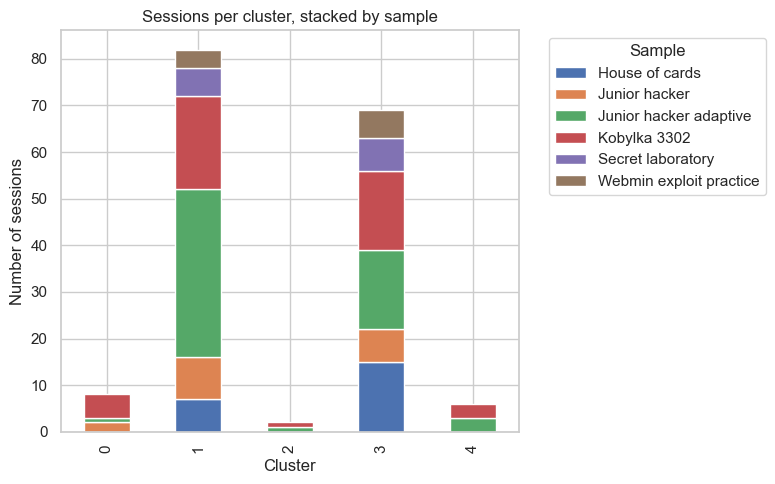

sample,House of cards,Junior hacker,Junior hacker adaptive,Kobylka 3302,Secret laboratory,Webmin exploit practice
cluster,,,,,,
0,0.000,0.250,0.125,0.625,0.000,0.000
1,0.085,0.110,0.439,0.244,0.073,0.049
2,0.000,0.000,0.500,0.500,0.000,0.000
3,0.217,0.101,0.246,0.246,0.101,0.087
4,0.000,0.000,0.500,0.500,0.000,0.000


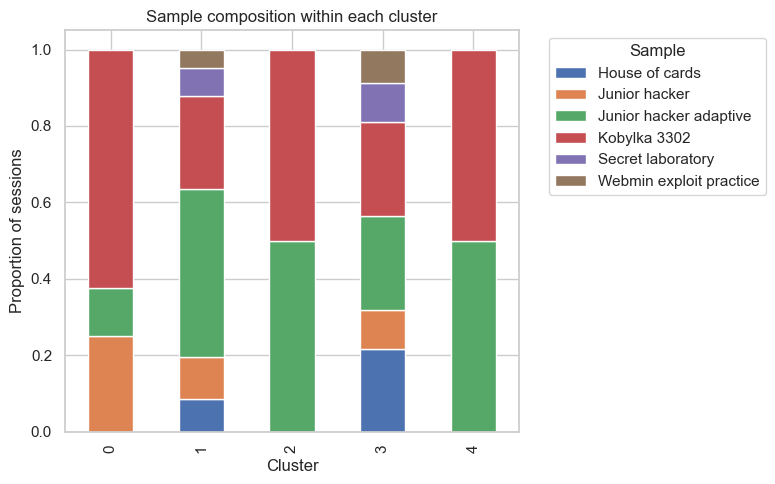

In [137]:
import pandas as pd
import matplotlib.pyplot as plt

# Crosstab: cluster x sample
ct_counts = pd.crosstab(df_clust["cluster"], df_clust["sample"]).sort_index()

# display(ct_counts)

# Plot: stacked bar (counts)
plt.figure(figsize=(8, 5))
ct_counts.plot(
    kind="bar",
    stacked=True,
    ax=plt.gca()
)
plt.xlabel("Cluster")
plt.ylabel("Number of sessions")
plt.title("Sessions per cluster, stacked by sample")
plt.legend(title="Sample", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

ct_props = ct_counts.div(ct_counts.sum(axis=1), axis=0)

display(ct_props.round(3))

plt.figure(figsize=(8, 5))
ct_props.plot(
    kind="bar",
    stacked=True,
    ax=plt.gca()
)
plt.xlabel("Cluster")
plt.ylabel("Proportion of sessions")
plt.title("Sample composition within each cluster")
plt.legend(title="Sample", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()
